## Inteligență Artificială  Tema 1 - 2025: Sokoban

Responsabili:
- Andrei Olaru
- Cătălin Chiru
- Andrei Dugăeșescu
- Mihai Nan
- Vlad Matei Drăghici
- Alexandru Baciu
- Bogdan-Andrei Sprîncenatu

In [2]:
from sokoban import Map, save_images, create_gif
import time

# Creating a map 

In [2]:
# Maps can be created using the Map class
map_from_init = Map(5, 5, 0, 0, [('box1', 1, 3)], [(4, 4)], [(3,3), (3,4), (3,1)], 'easy_map1')

# Maps can be created through yaml files
map_from_yaml = Map.from_yaml('tests/easy_map1.yaml')

assert str(map_from_init) == str(map_from_yaml), "Reading from yaml file Failed"

In [3]:
# Maps can also be created from their string representation
map_str = str(map_from_init)
map_from_str = Map.from_str(map_str)

assert str(map_from_init) == str(map_from_str), "String conversion Failed"

# Solving a map 

In [6]:
# playmap = Map(5, 5, 0, 0, [('box1', 1, 3)], [(4, 4)], [(3,3), (3,4), (3,1)], 'easy_map1')
playmap = Map.from_yaml('tests/easy_map1.yaml')

# Visualizing a map 

In [27]:
print(playmap)


_ _ _ _ X 
_ _ _ _ _ 
_ _ _ _ _ 
_ _ _ B _ 
P _ _ _ _ 


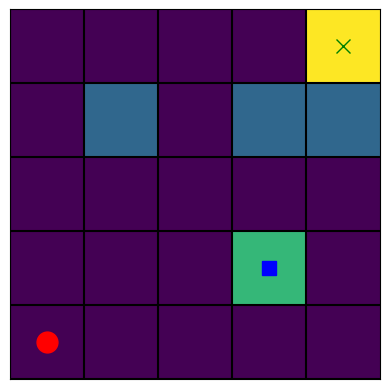

In [7]:
playmap.plot_map()

In [77]:
# To save the state of a map to disk:
playmap.save_map('images', 'easy_map2_init.png')

In [12]:
def expand_state(state: Map) -> list[Map]:
    moves = state.filter_possible_moves()
    new_states = []

    for move in moves:
        new_state = state.copy()
        new_state.apply_move(move)
        new_states.append(new_state)

    return new_states


import queue

def in_bounds(state: Map, x: int, y: int) -> bool:
    return x >= 0 and y >= 0 and x < state.length and y < state.width

def dist(a, b):
    return abs(a.x - b[0]) + abs(a.y - b[1])


def costf(state: Map, distances: list[list[int]]) -> list[int]:
    target_distances = 0
    player_distances = []

    for box in state.boxes.values():
        x, y = box.x, box.y
        target_distances += distances[box.x][box.y]

        box_vicinities = [[(x - 1, y), (x + 1, y)], [(x, y - 1), (x, y + 1)]]
        box_pos = []
        for axis in (box_vicinities):
            valid = True

            for neigh in axis:
                if not in_bounds(state, neigh[0], neigh[1]) or state.map[neigh[0]][neigh[1]] in [1, 2]: # [box, obstacle]
                    valid = False
                    break

            if valid:
                box_pos += axis

        d = lee(state, [(state.player.x, state.player.y)], [1, 2])
        
        if len(box_pos) == 0:
            if distances[box.x][box.y] != 0:
                return tuple([1000])
            
            continue
        
        dd = min(map(lambda p: d[p[0]][p[1]],box_pos))
        player_distances.append(dd)

    player_distances.sort()
    sort_key = tuple([target_distances, *player_distances])
    return sort_key


def lee(state: Map, starts: list[tuple[int, int]], invalid_values: list[int]):
    goal_distances = list(map(lambda r: list(map(lambda _: 1000, r)), state.map))

    q = queue.Queue()
    for x, y in starts:
        goal_distances[x][y] = 0
        q.put((x, y))
    
    while not q.empty():
        x, y = q.get()

        for x2, y2 in [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]:
            if not in_bounds(state, x2, y2):
                continue

            if state.map[x2][y2] in invalid_values: # OBSTACLE
                continue

            if goal_distances[x2][y2] == -1 or goal_distances[x2][y2] > goal_distances[x][y] + 1:
                goal_distances[x2][y2] = goal_distances[x][y] + 1
                q.put((x2, y2))

    return goal_distances

# LRTA*

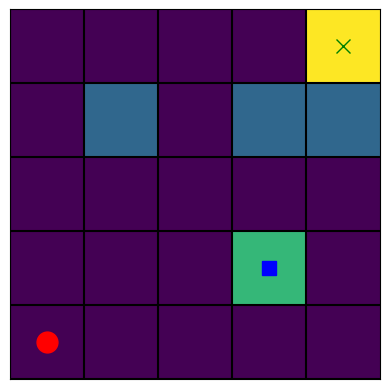

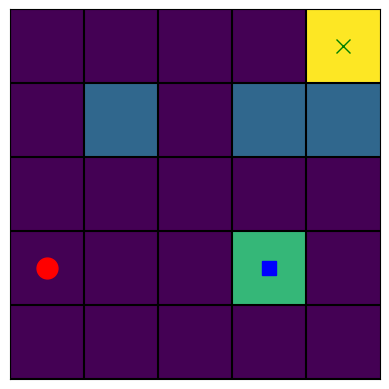

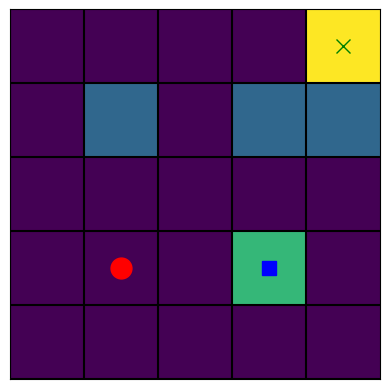

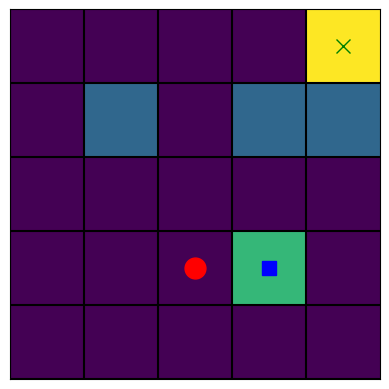

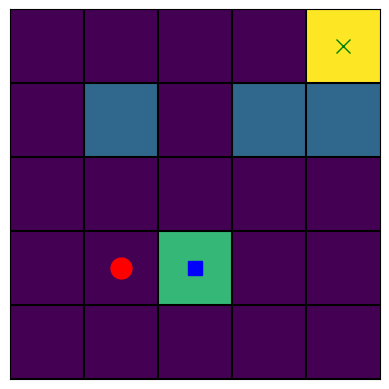

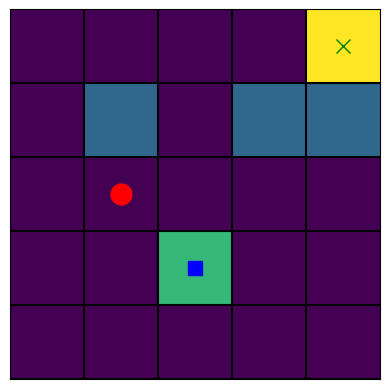

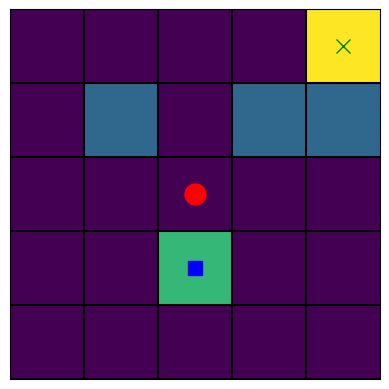

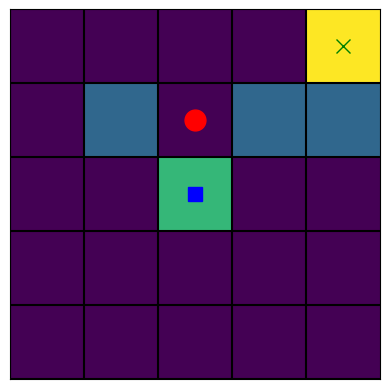

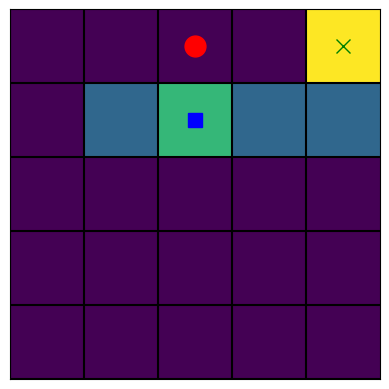

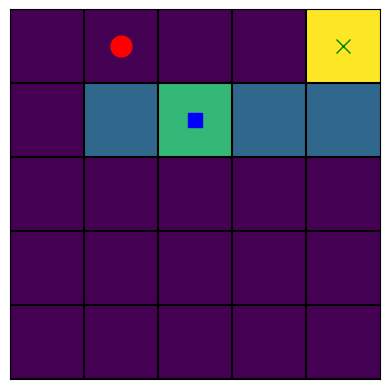

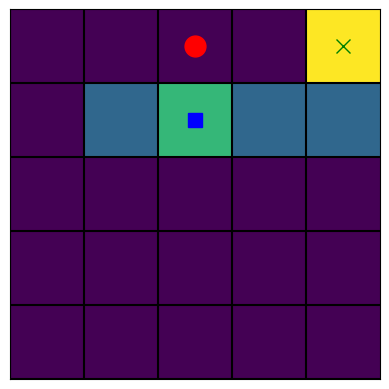

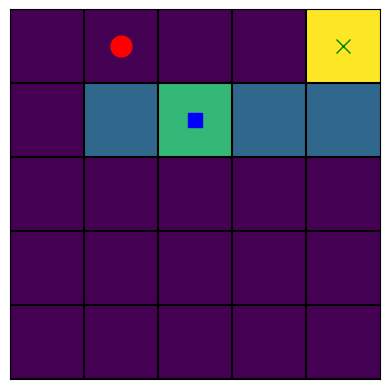

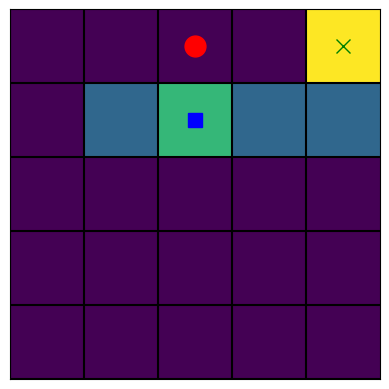

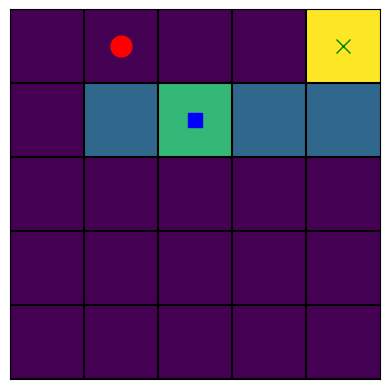

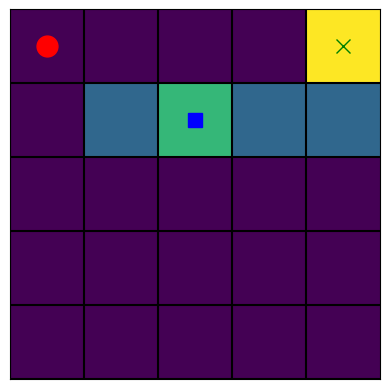

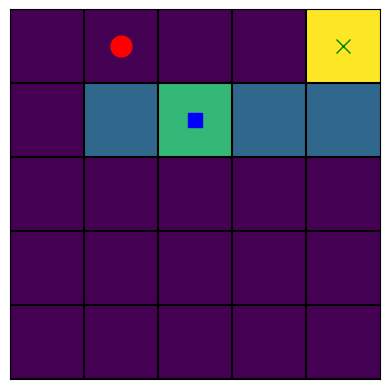

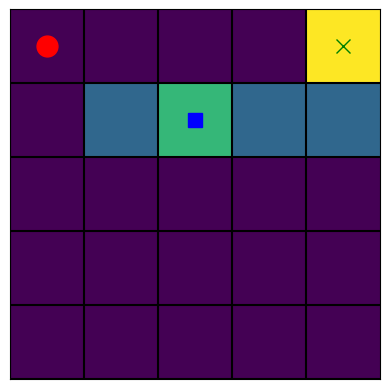

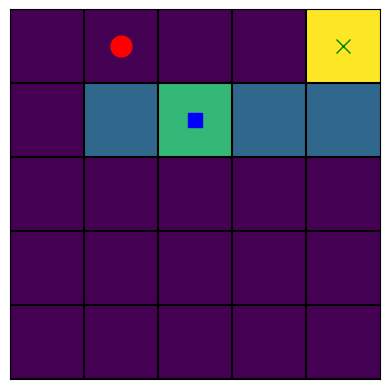

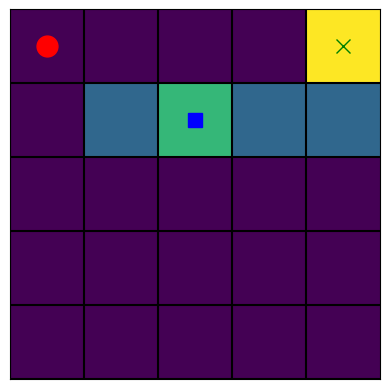

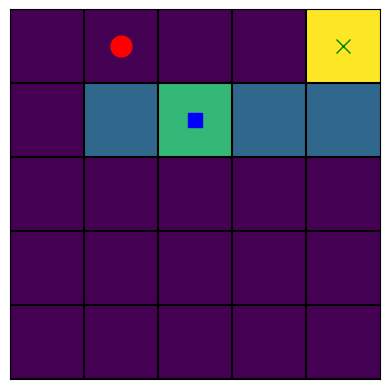

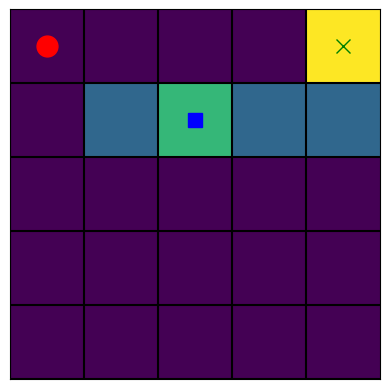

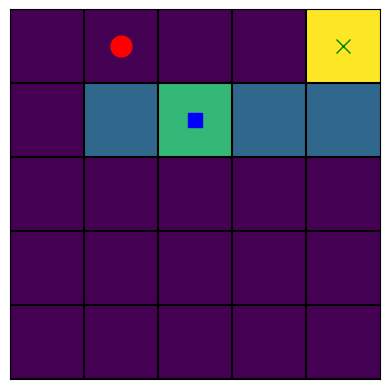

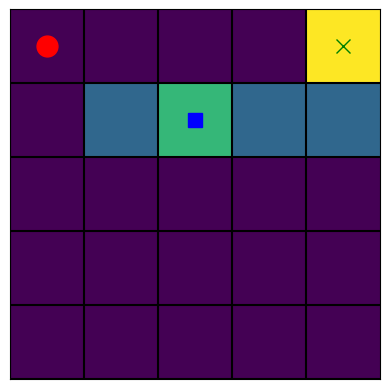

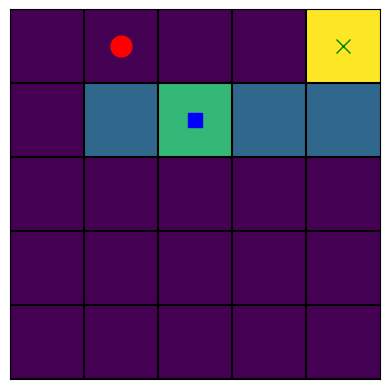

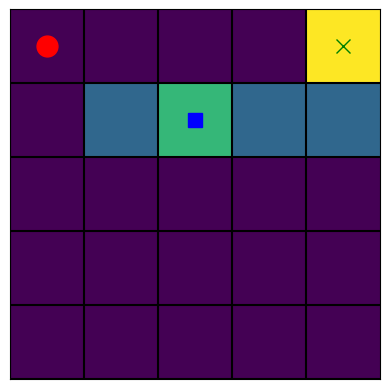

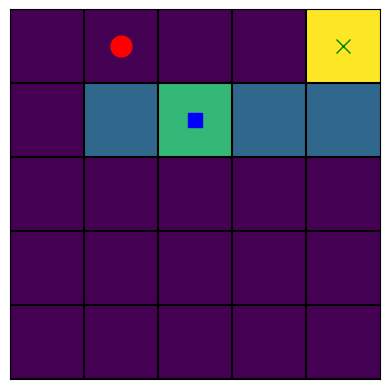

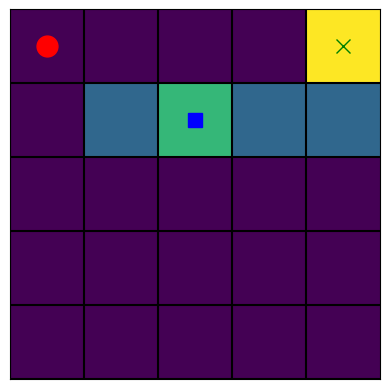

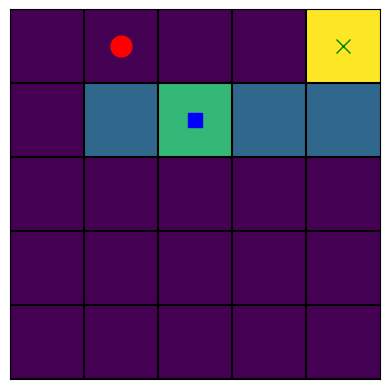

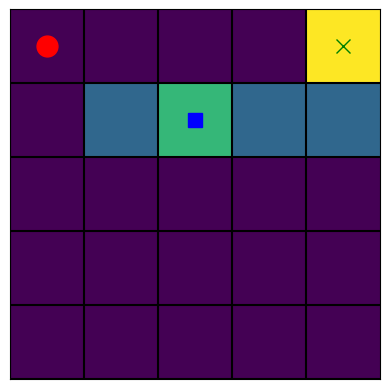

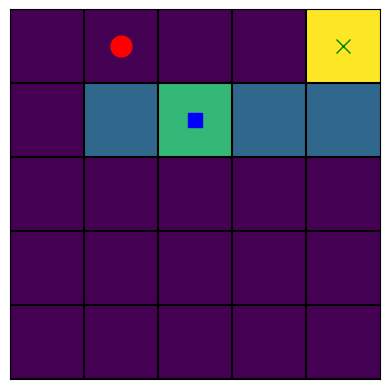

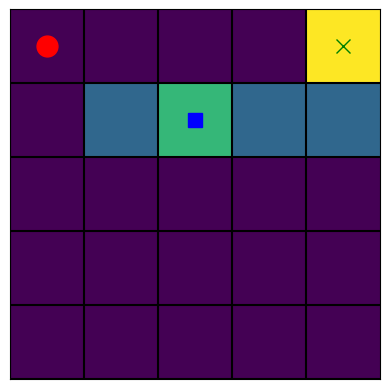

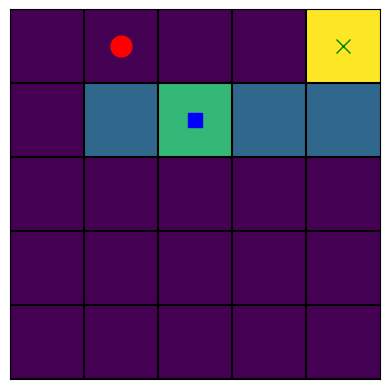

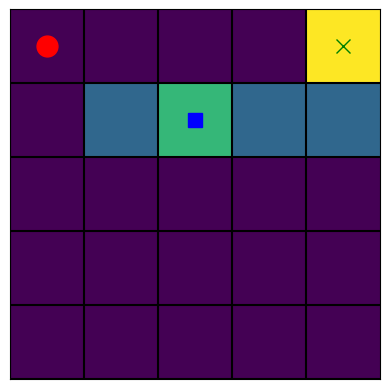

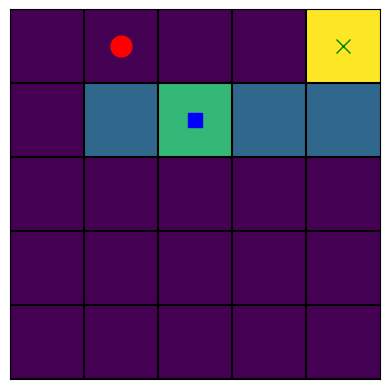

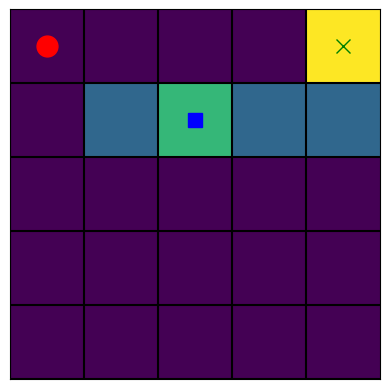

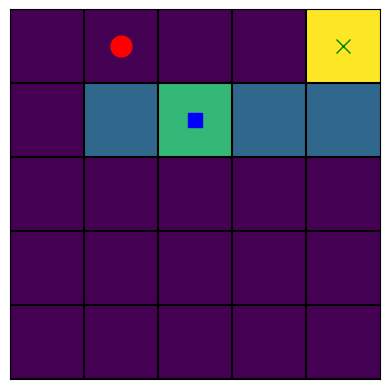

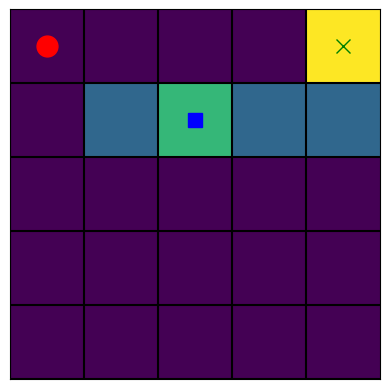

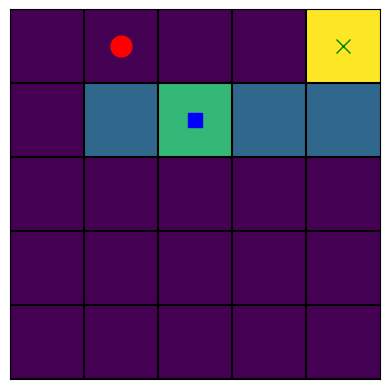

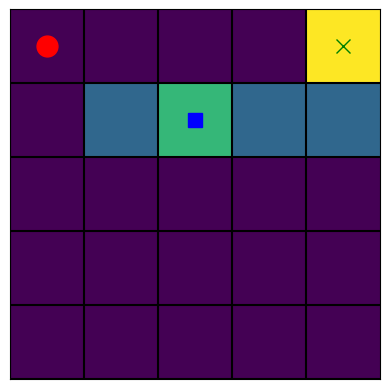

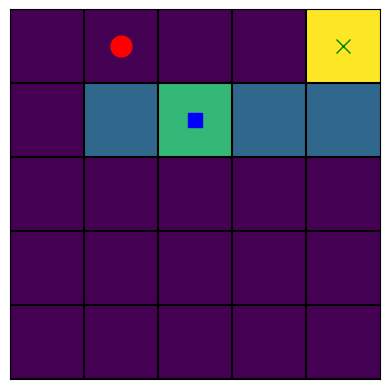

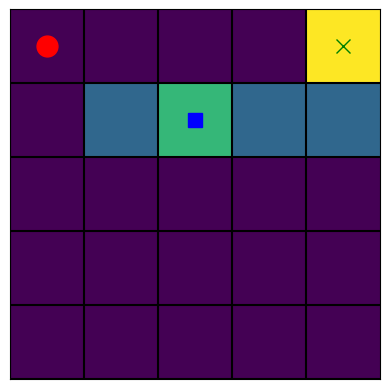

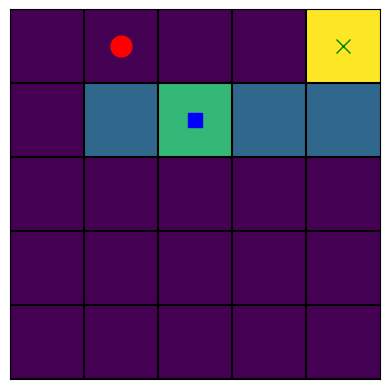

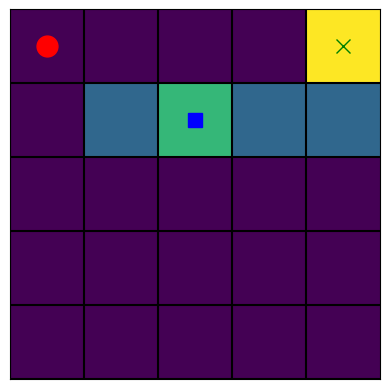

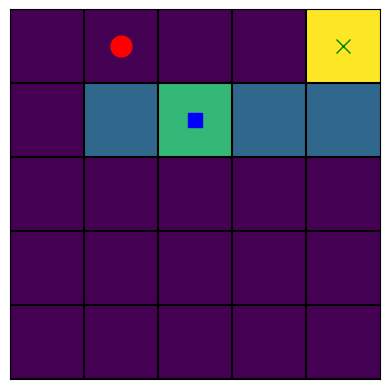

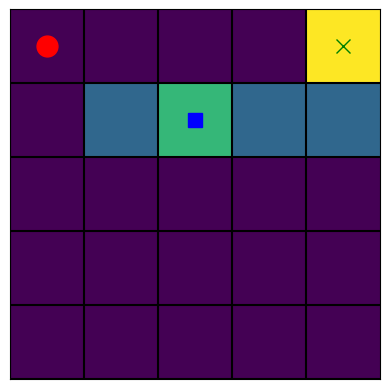

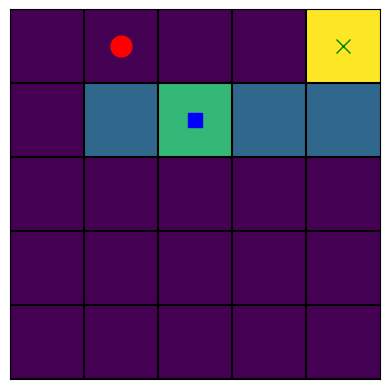

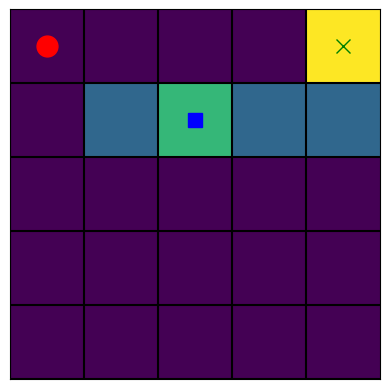

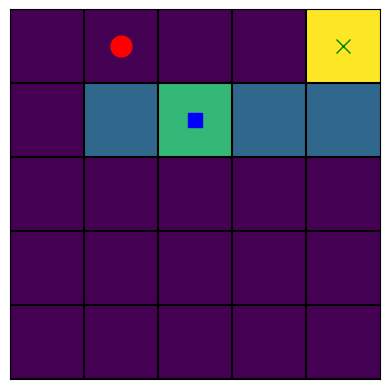

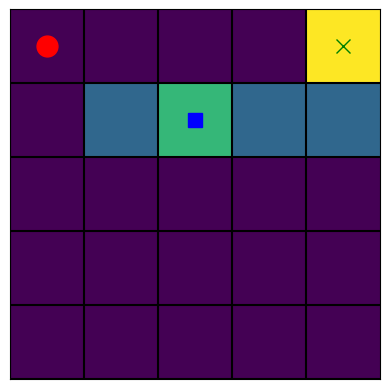

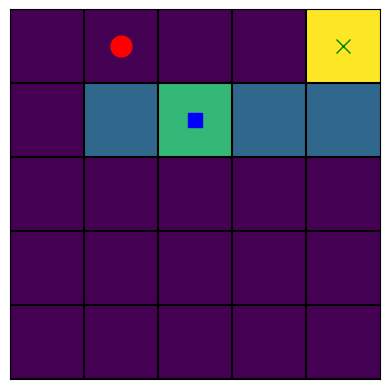

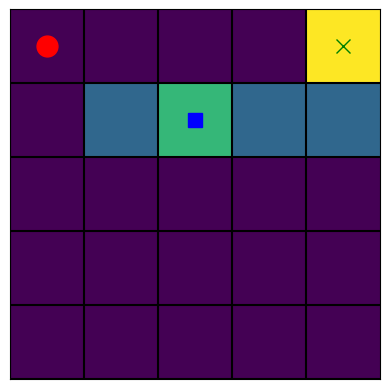

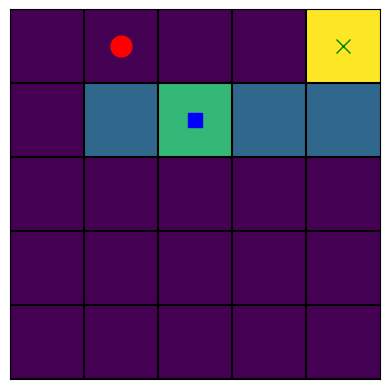

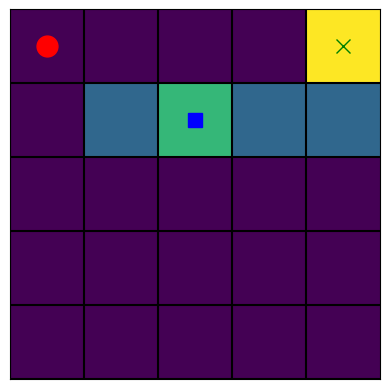

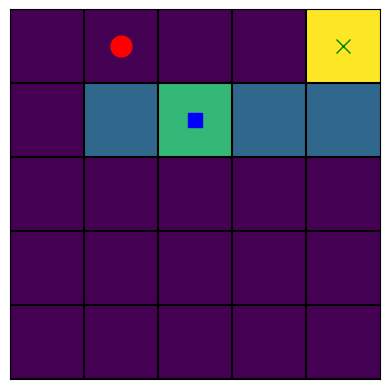

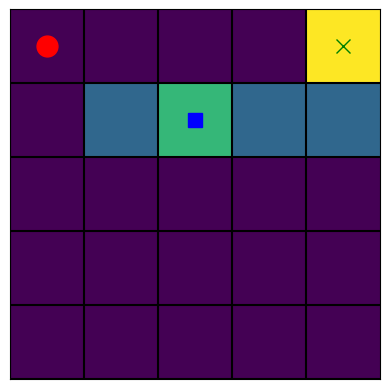

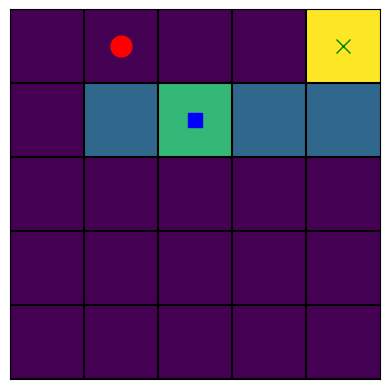

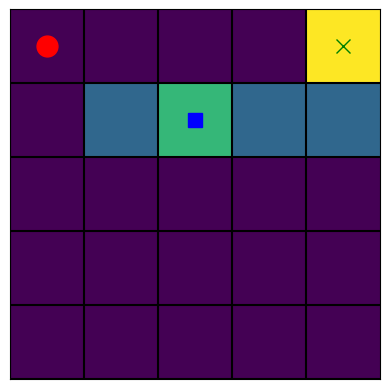

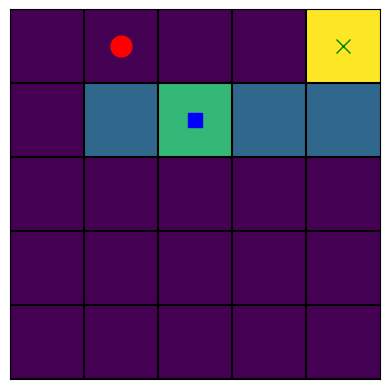

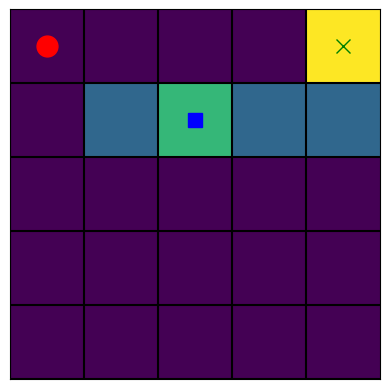

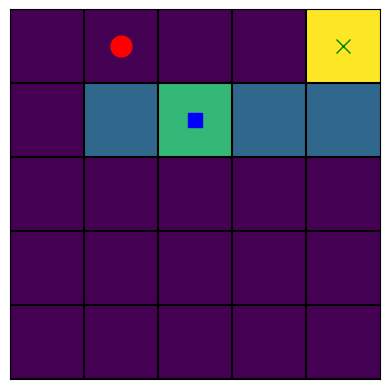

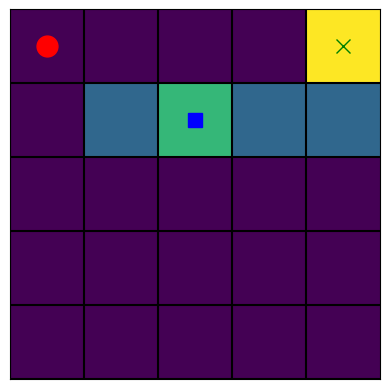

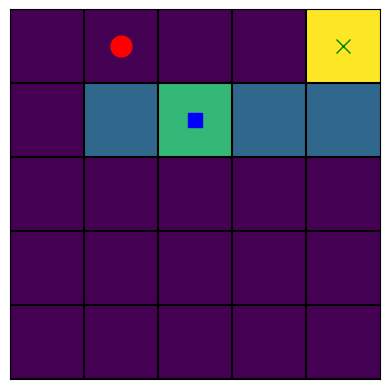

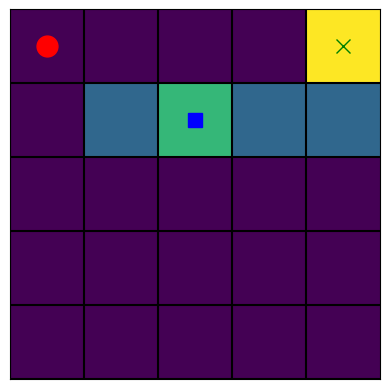

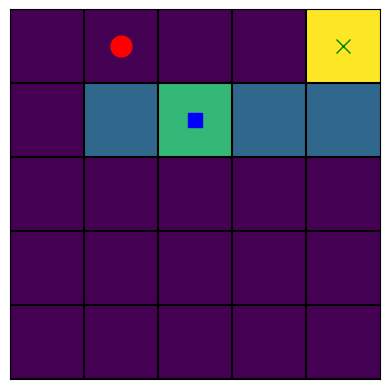

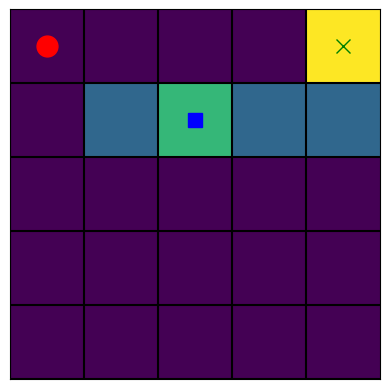

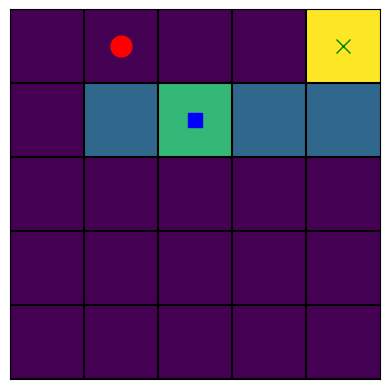

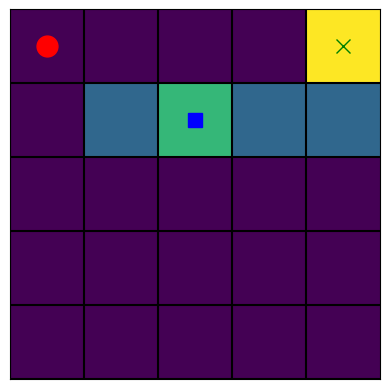

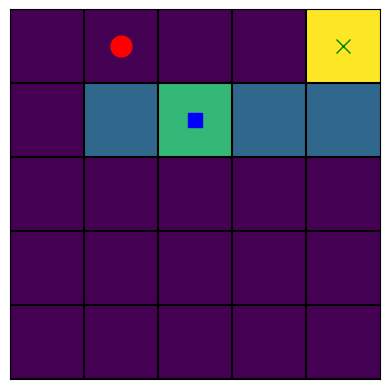

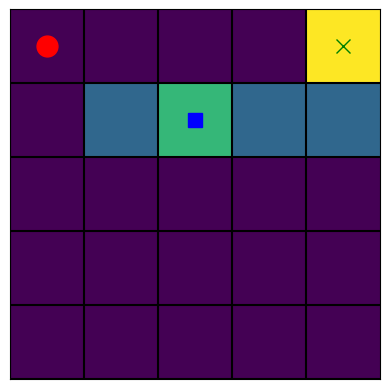

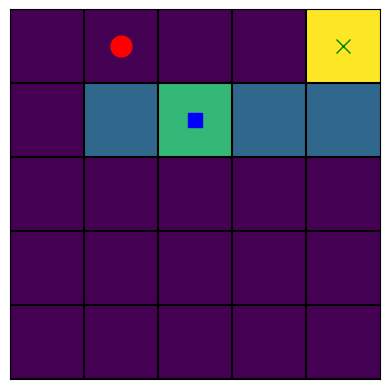

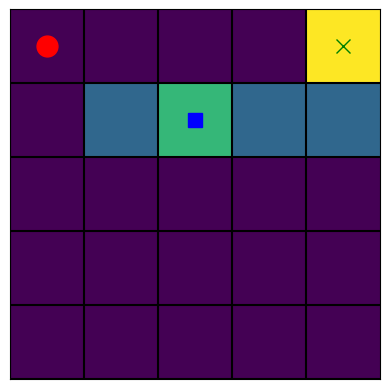

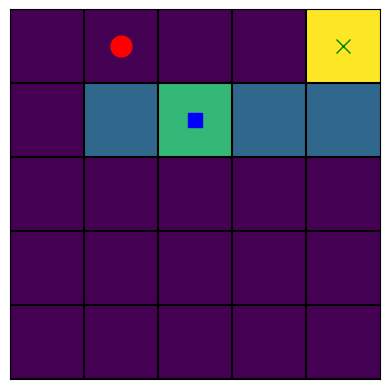

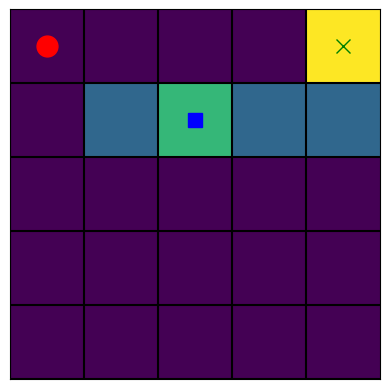

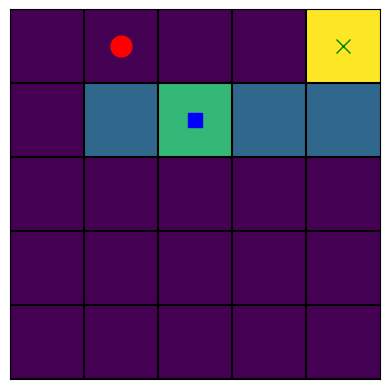

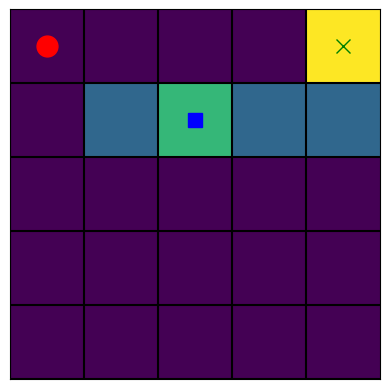

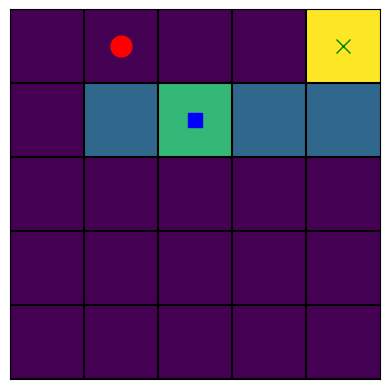

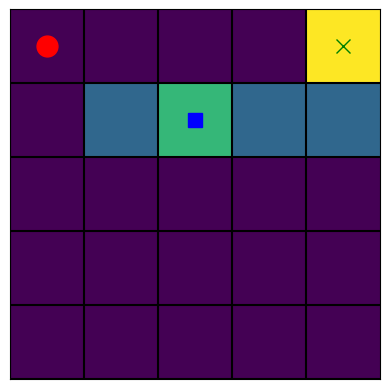

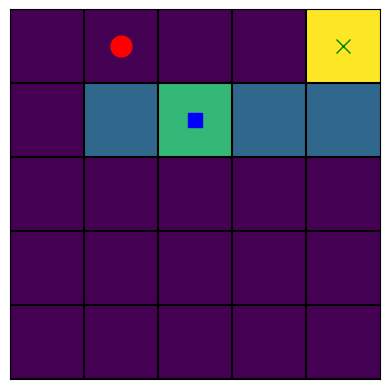

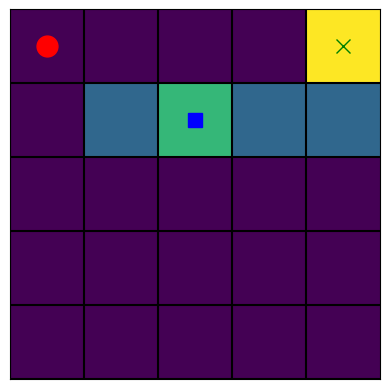

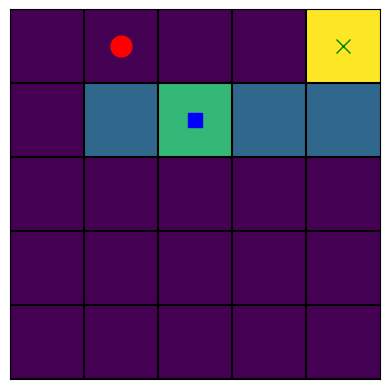

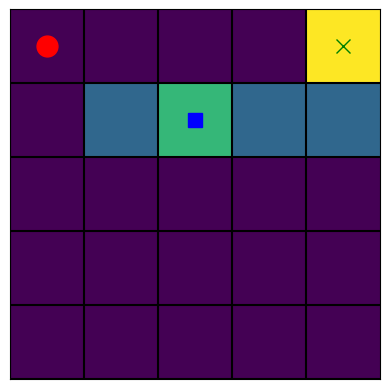

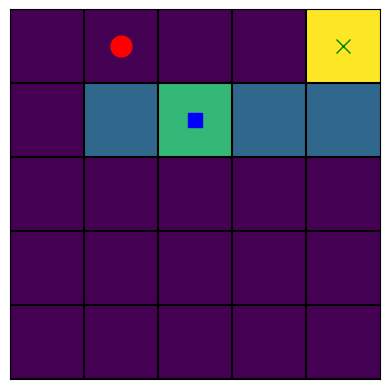

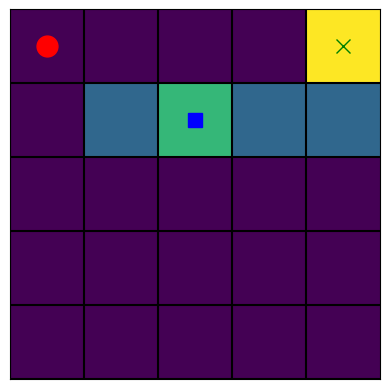

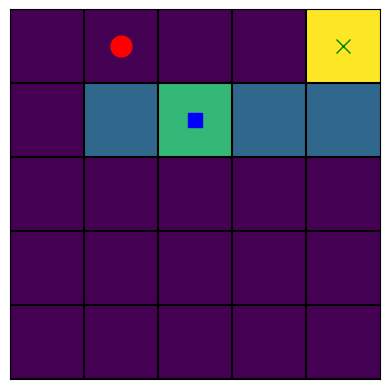

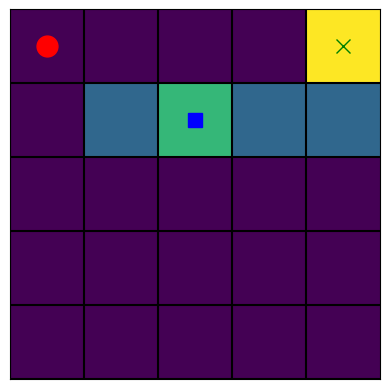

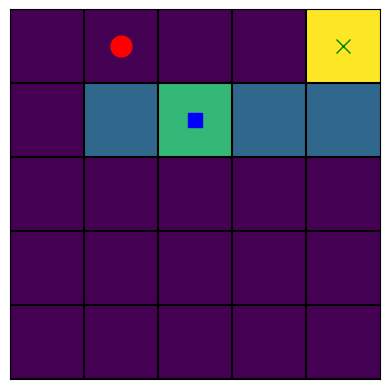

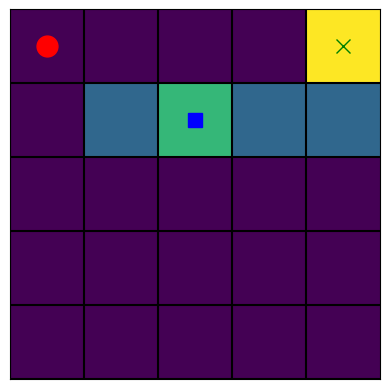

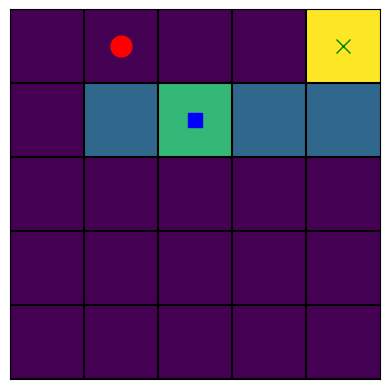

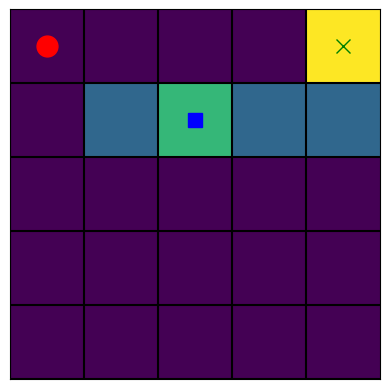

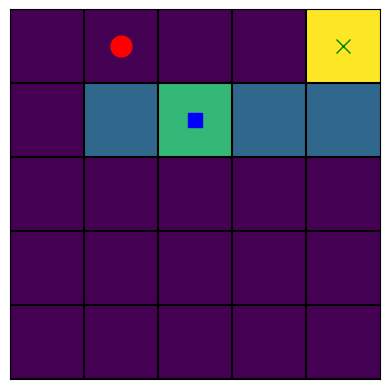

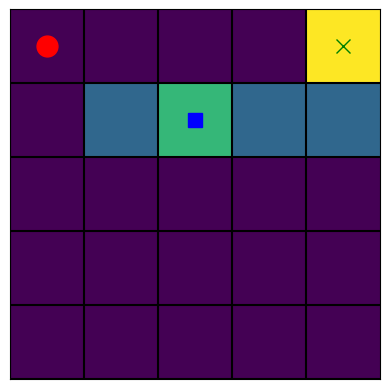

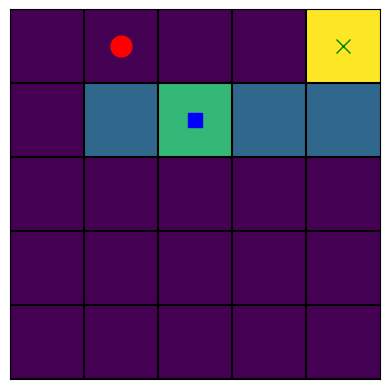

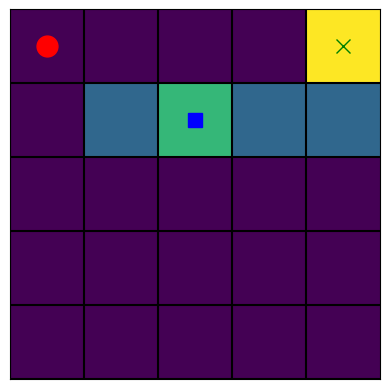

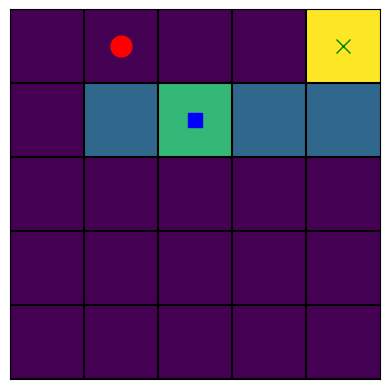

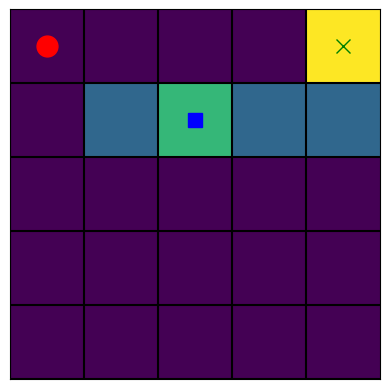

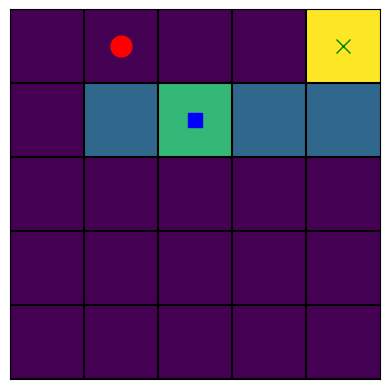

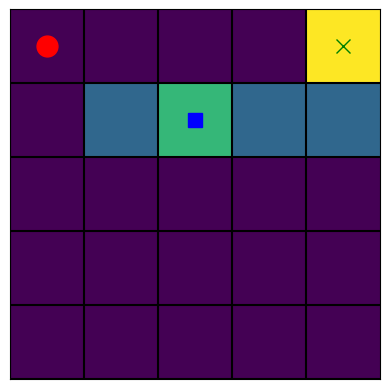

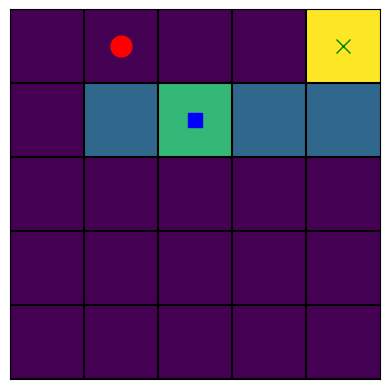

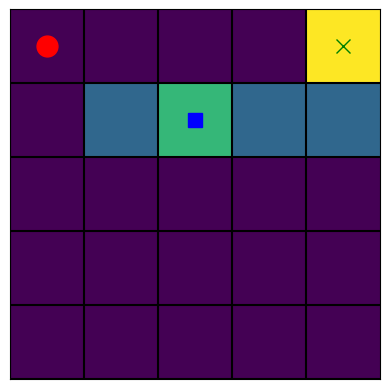

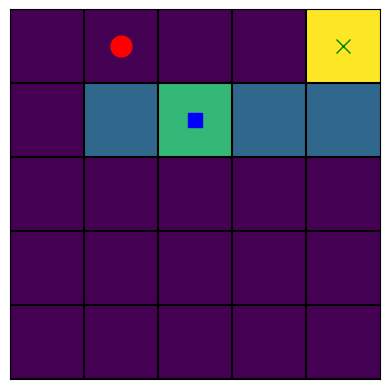

In [17]:
def astar(state: Map):
    goal_distances = lee(state, state.targets, [1])
    costs = {}

    for _ in range(100):
        if state.is_solved():
            print('gata')
            return
        
        state.plot_map()
        next_states = expand_state(state)
        next_costs = []
        for state in next_states:
            encoding = state.__str__()
            cost = 0

            if encoding not in costs:
                cost = sum(costf(state, goal_distances))
                costs[encoding] = cost
            else:
                cost = costs[encoding]

            next_costs.append((1 + cost, state))
    
        cost, next_state = min(next_costs)
        costs[state.__str__()] = cost
        state = next_state
    

astar(playmap)

# Beam search

round 0: best candidate score (6, 2)


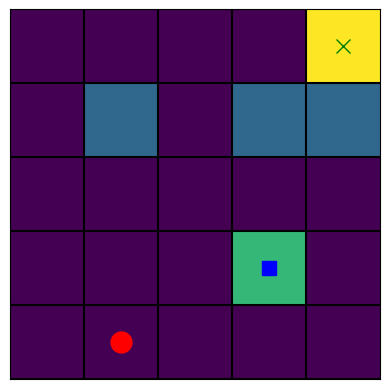

round 1: best candidate score (6, 1)


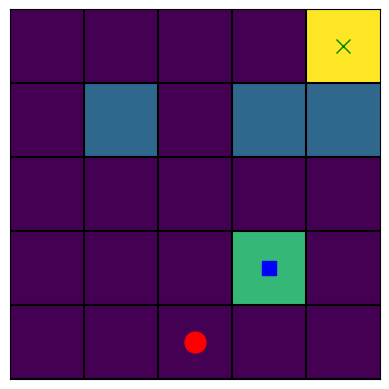

round 2: best candidate score (6, 0)


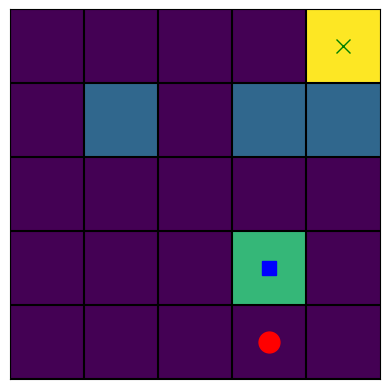

round 3: best candidate score (5, 0)


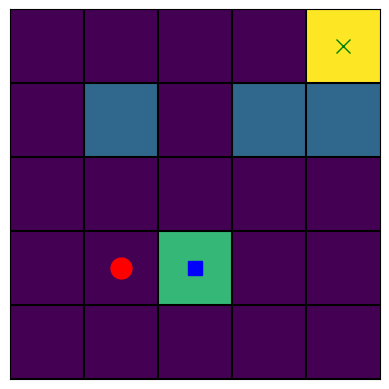

round 4: best candidate score (5, 1)


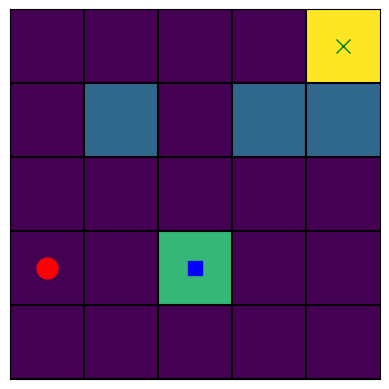

round 5: best candidate score (5, 0)


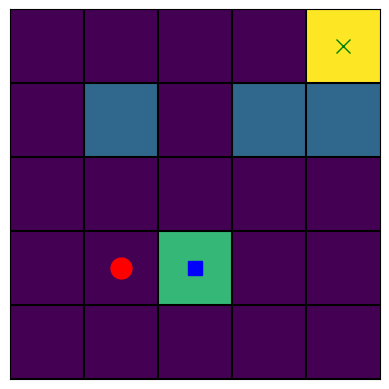

round 6: best candidate score (4, 0)


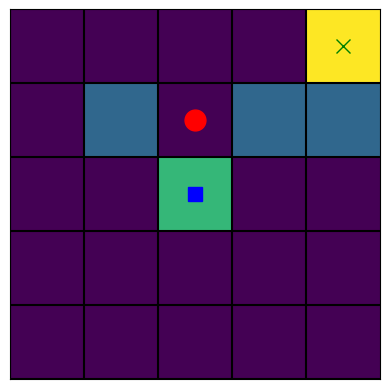

round 7: best candidate score (3, 0)


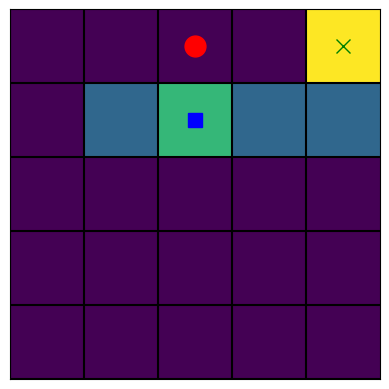

round 8: best candidate score (2, 6)


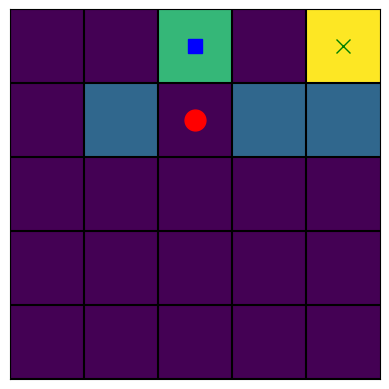

round 9: best candidate score (2, 5)


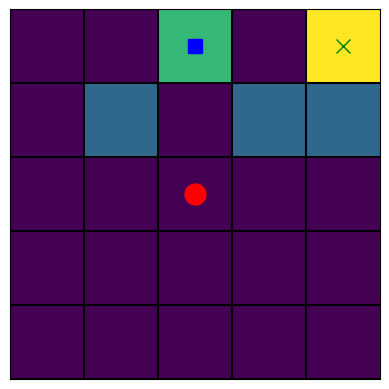

round 10: best candidate score (2, 4)


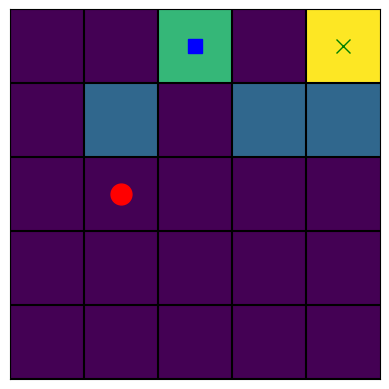

round 11: best candidate score (2, 3)


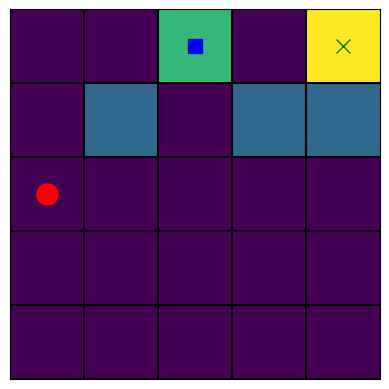

round 12: best candidate score (2, 2)


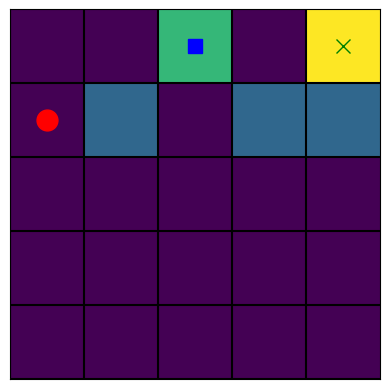

round 13: best candidate score (2, 1)


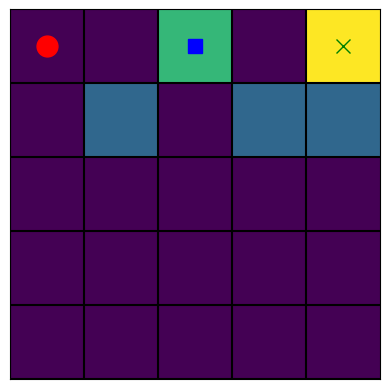

round 14: best candidate score (2, 0)


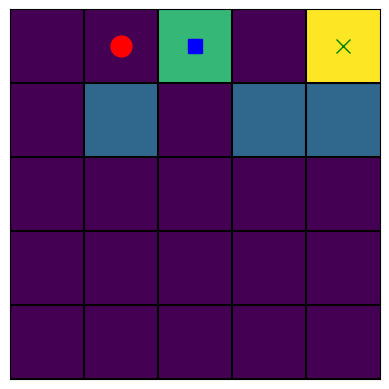

round 15: best candidate score (1, 0)


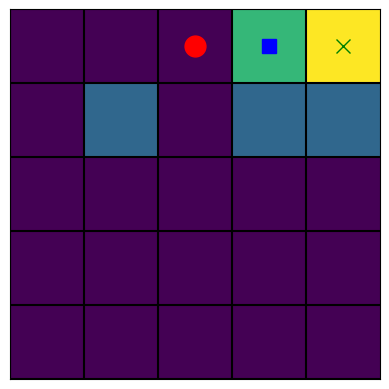

round 16: best candidate score (0,)


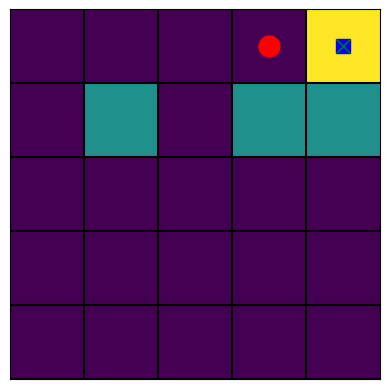

game won


In [ ]:


def beam_search(state: Map, k: int):
    goal_distances = lee(state, state.targets, [1])

    cst = lambda c: costf(c, goal_distances)
    beam = expand_state(state)


    for i in range(50):
        print(f"round {i}: best candidate score {cst(beam[0])}")
        beam[0].plot_map()

        new_beam = []

        for state in beam:
            if state.is_solved():
                print("game won")
                return

            new_states = expand_state(state)
            new_beam += new_states

        beam = new_beam
        beam = sorted(beam, key=cst)
        beam = beam[:k]


beam_search(playmap, 300)